In [13]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
cols = ['ID(original)', 'ID' , 'Q' , 'A']
data = pd.read_csv('COQB-19_crowdsourced_06202020.csv', sep=',', names=cols, header=None, encoding='latin-1',skiprows=1)
data = data.dropna()
Questions = data['Q']
ID= data['ID'].tolist()
corpus = Questions.tolist()
Answers =data['A'].tolist()

In [15]:
lemmatizer = WordNetLemmatizer()
def stemSentence(sentence):
    token_words= word_tokenize(sentence)
    lematized_tokens = [lemmatizer.lemmatize(w) for w in token_words]
    return "  ".join(lematized_tokens)

In [16]:
stemmed_corpus = []
SC = []
for i in range(len(corpus)):
  stemmed_corpus.append((i,stemSentence(corpus[i].lower())))
  SC.append(stemSentence(corpus[i].lower()))

In [17]:
vectorizer = TfidfVectorizer()

In [18]:
X = vectorizer.fit_transform(SC)

In [19]:
mat_x = X.toarray()

In [20]:
def answer_question(question, corpus_X):
  """  returns (top_idx,  top_idx_score, all_scores)
  top_idx: index of most similar question
  top_idx_score:  score of most similar question.
  all_scores: scores of all candidates.
  """
  lematized_question = stemSentence(question)
  question_x = vectorizer.transform([lematized_question])
  sim_scores = cosine_similarity(question_x,  corpus_X).ravel()
  top_idx = np.argmax(sim_scores)
  return top_idx, sim_scores[top_idx], sim_scores

In [21]:
x2 = 'What Is covid 19?'

In [22]:
answer_idx, answer_score,_ = answer_question(x2.lower(), mat_x)
print('Similarity score = ', answer_score)
print('Most similiar question: ', corpus[stemmed_corpus[answer_idx][0]])
print('suggested answer: ', Answers[stemmed_corpus[answer_idx][0]])

Similarity score =  1.0000000000000002
Most similiar question:  What is COVID-19?
suggested answer:  COVID-19 is the infectious disease caused by the most recently discovered coronavirus. This new virus and disease were unknown before the outbreak began in Wuhan, China, in December 2019. More information is available from the World Health Organization.


In [23]:
def compute_precision_recall_at_threshold(corpus, ids, corpus_X, threshold):
  precision_list = []
  recall_list = []
  for i,test_doc in enumerate(corpus):
    if i%20 != 0:
    # this is done only to speed calculations a bit. we compute metrics based
    # on 5% of data.
      continue
    _,_,  scores = answer_question(test_doc, corpus_X)
    preds = scores >= threshold
    labels = np.array([a_id==ids[i] for a_id in ids])
    precision_list.append(precision_score(labels, preds))
    recall_list.append(recall_score(labels, preds))
  return np.mean(precision_list),  np.mean(recall_list)

In [24]:
probability_thresholds = np.linspace(0,1, num=50)
prec_list =[]
rec_list =[]
for threshold in probability_thresholds:
  cur_prec, cur_rec = compute_precision_recall_at_threshold(corpus, ID,  mat_x,threshold)
  prec_list.append(cur_prec)
  rec_list.append(cur_rec)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

Text(0, 0.5, 'precision')

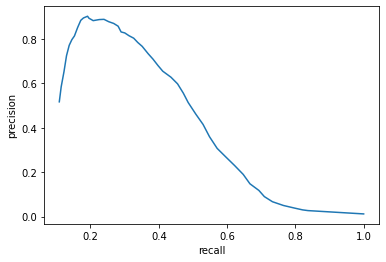

In [25]:
plt.plot(rec_list,  prec_list)
plt.xlabel('recall')
plt.ylabel('precision')

In [26]:
def compute_prec_recall_at_k(corpus, ids, corpus_X, k=5):
  prec_at_k_list = []
  recall_at_k_list = []
  for i,test_doc in enumerate(corpus):
    if i%20 != 0:
    # this is done only to speed calculations a bit. we compute metrics based
    # on 5% of data.
      continue
    _,_,  scores = answer_question(test_doc, corpus_X)
    top_k_idx = np.argsort(scores)[::-1][:k]
    top_k_labels = [ids[idx] for idx in top_k_idx]
    num_true_labels = np.sum([a_id==ids[i] for a_id in ids])
    num_true_in_top_k = np.sum([a_id==ids[i] for a_id in top_k_labels])
    cur_prec_at_k = num_true_in_top_k/k
    cur_recall_at_k = num_true_in_top_k / num_true_labels
    recall_at_k_list.append(cur_recall_at_k)
    prec_at_k_list.append(cur_prec_at_k)
  return np.mean(prec_at_k_list), np.mean(recall_at_k_list)

In [27]:
print("Prec, Recall at 1 : ",  compute_prec_recall_at_k(corpus, ID, mat_x, 1))

Prec, Recall at 1 :  (0.940677966101695, 0.13295137131073784)


In [28]:
print("Prec, Recall at 5 : ",  compute_prec_recall_at_k(corpus, ID, mat_x, 5))

Prec, Recall at 5 :  (0.6728813559322034, 0.29087012872019286)


In [29]:
print("Prec,Recall at 10 : ",  compute_prec_recall_at_k(corpus, ID, mat_x, 10))

Prec,Recall at 10 :  (0.5483050847457626, 0.3899382637426586)
